# Decision Trees & Random Forests

## Summary

- Decision Trees
- Ensemble learning
- Random Forests

## Decision Trees

(Heavily inspired by Chapter 6 of [Hands-On Machine Learning](https://github.com/ageron/handson-ml2) by Aurélien Géron)

### Decision Trees in a nutshell

- Supervised method, used for classification or regression.
- Build a tree-like structure based on a series of questions on the data.

[![Decision Tree Example](images/dt_pdsh.png)](https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html)

### Example: training a Decision Tree to classify flowers

[Iris](https://archive.ics.uci.edu/ml/datasets/iris) is a well-known multiclass dataset. It contains 3 classes of flowers with 50 samples each. There are a total of 4 features for each sample:

- sepal length
- sepal width
- petal length
- petal width

### Environment setup

In [1]:
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
import graphviz

Python version: 3.7.5


In [2]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

In [3]:
import sklearn

print(f"scikit-learn version: {sklearn.__version__}")

from sklearn.datasets import load_iris
from sklearn.tree import (
    DecisionTreeClassifier,
    DecisionTreeRegressor,
    plot_tree,
    export_graphviz,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

scikit-learn version: 0.22.1


In [4]:
# Plot the decision boundary for a model using 2 features
# Taken from https://github.com/ageron/handson-ml2/blob/master/06_decision_trees.ipynb
def plot_iris_decision_boundary(
    model, X, y, axes=[0, 7.5, 0, 3], legend=True, plot_training=True
):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = model.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#fafab0", "#a0faa0", "#9898ff"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if plot_training:
        plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "g^", label="Iris versicolor")
        plt.plot(X[:, 0][y == 2], X[:, 1][y == 2], "bs", label="Iris virginica")
        plt.axis(axes)
    plt.xlabel("Petal length", fontsize=14)
    plt.ylabel("Petal width", fontsize=14)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

In [5]:
# Load the Iris dataset
iris = load_iris()

# Put it into a DataFrame for visualization purposes
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
# Add target and class columns to DataFrame
df_iris["target"] = iris.target
df_iris["class"] = iris.target_names[iris.target]
# Show 10 random samples
df_iris.sample(n=10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,class
52,6.9,3.1,4.9,1.5,1,versicolor
61,5.9,3.0,4.2,1.5,1,versicolor
17,5.1,3.5,1.4,0.3,0,setosa
119,6.0,2.2,5.0,1.5,2,virginica
67,5.8,2.7,4.1,1.0,1,versicolor
73,6.1,2.8,4.7,1.2,1,versicolor
101,5.8,2.7,5.1,1.9,2,virginica
112,6.8,3.0,5.5,2.1,2,virginica
114,5.8,2.8,5.1,2.4,2,virginica
124,6.7,3.3,5.7,2.1,2,virginica


In [6]:
# Use only last two features (petal length and width)
# Thus, we can plot a 2D decision boundary

x_train_2feat = iris.data[:, 2:]
y_train_2feat = iris.target

print(f"x_train: {x_train_2feat.shape}")
print(f"y_train: {y_train_2feat.shape}")

x_train: (150, 2)
y_train: (150,)


In [7]:
# Train a DT on the simplified dataset
dt_model = DecisionTreeClassifier(max_depth=2, random_state=42)
dt_model.fit(x_train_2feat, y_train_2feat)

# Compute accuracy on training set
acc = dt_model.score(x_train_2feat, y_train_2feat)
print(f"Training accuracy: {acc:.5f}")

Training accuracy: 0.96000


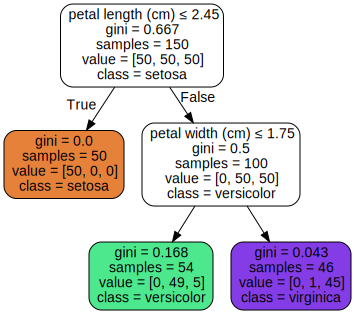

In [8]:
# Plot the DT
# If using Jupyter locally, install graphviz with this command: conda install python-graphviz
dot_data = export_graphviz(
    dt_model,
    out_file=None,
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    filled=True,
    rounded=True,
    special_characters=True,
)
graphviz.Source(dot_data)

### Tree nodes

Each node is a step in the decision process, starting with the *root node* (depth 0). Leaf nodes represent predictions of the model.

Node attributes are:

- **Gini**: measure of the node *impurity*.
- **Samples**: number of samples the node applies to.
- **Value**: number of samples of each class the node applies to.

### The Gini score

- $G_i = 1- \sum_{k=1}^K {p_{i, k}}^2$
- $p_{i, k}$: ratio of class `k` instances in the $i^{th}$ node.
- $Gini = 0$: all samples it applies to belong to the same class ("pure" node).

Other possible measure: *entropy* (level of disorder).

### Example: Gini scores for the trained Decision Tree

- Root node:

$$G_0 = 1 - ((\frac{50}{150})^2 + (\frac{50}{150})^2 + (\frac{50}{150})^2) = 1 - (\frac{1}{9} + \frac{1}{9} + \frac{1}{9}) = \frac{2}{3}$$

- Depth 1, left node:

$$G_1 = 1 - ((\frac{50}{50})^2 + (\frac{0}{50})^2 + (\frac{0}{50})^2) = 1 - (1 + 0 + 0) = 0$$

- Depth 2, left node:

$$G_3 = 1 - ((\frac{0}{54})^2 + (\frac{49}{54})^2 + (\frac{5}{54})^2) \simeq 0.168$$

### Example: decision boundaries for the trained Decision Tree

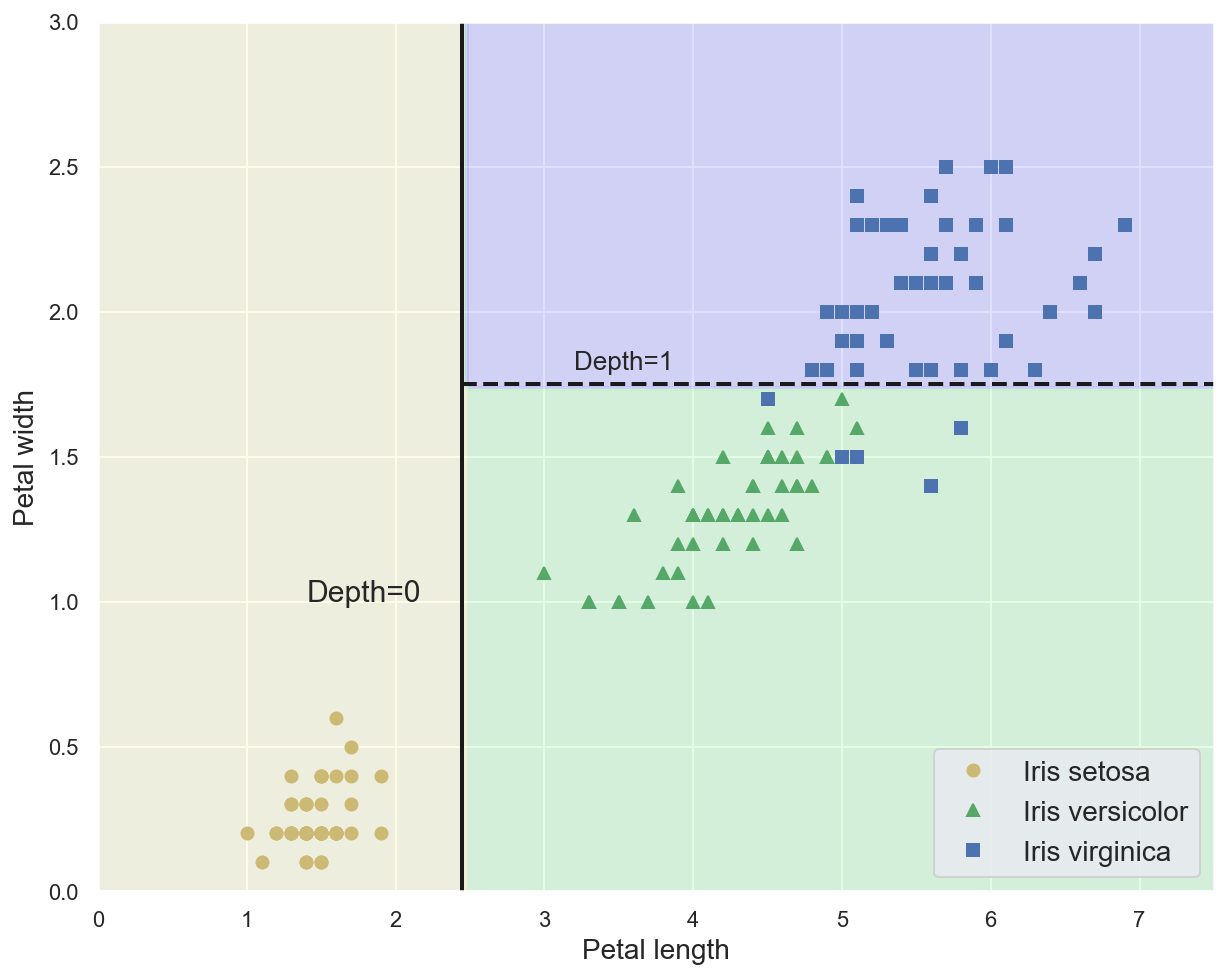

In [9]:
plot_iris_decision_boundary(dt_model, x_train_2feat, y_train_2feat)
# Plot separation lines
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.show()

### Using a Decision Tree for predictions

1. Using the new sample data, the tree is traversed to find the leaf node for that sample.
1. Class probabilities are the ratios of samples of each class for this node.

In [10]:
# Define some new flower data
x_new = [[5, 1.5]]

# Print predicted class probabilities
# 0/54 for "setosa", 49/54 for "versicolor", 5/54 for "virginica"
print(dt_model.predict_proba(x_new))

# Print predicted class
print(iris.target_names[dt_model.predict(x_new)])

[[0.         0.90740741 0.09259259]]
['versicolor']


### The training process

The CART (*Classification And Regression Tree*) algorithm creates binary trees.

At each depth, it looks for the highest *Gini gain* by finding the feature and the threshold that produces the *purest* subsets (weighted by their size). Then, its splits the subsets recursively according to the same logic.

It stops once no split will further reduce impurity, or when it reaches the maximum depth.

### Example: training a Decision Tree on planar data

Three classes with 3 samples each, two features $x$ and $y$.

[![DT CART example](images/dt_cart_example.png)](https://victorzhou.com/blog/intro-to-random-forests/)

$G_{initial} = 1 - ((\frac{3}{9})^2 + (\frac{3}{9})^2 + (\frac{3}{9})^2) = \frac{2}{3}$

Impurity gain with $x=0.4$:

- $G_{left|x=0.4} = 1 - ((\frac{1}{1})^2 + (\frac{0}{1})^2 + (\frac{0}{1})^2) = 0\;\;G_{right|x=0.4} = 1 - ((\frac{2}{8})^2 + (\frac{3}{8})^2 + (\frac{3}{8})^2) = \frac{21}{32}$
- $Gain_{x=0.4} = G_{initial} - (\frac{1}{9}G_{left|x=0.4} + \frac{8}{9}G_{right|x=0.4}) = \frac{2}{3} - \frac{7}{12} = \frac{1}{12}$

Impurity gain with $x=2$:

- $G_{left|x=2} = 1 - ((\frac{3}{6})^2 + (\frac{3}{6})^2 + (\frac{0}{6})^2) = 0,5\;\;G_{right|x=2} = 1 - ((\frac{0}{3})^2 + (\frac{0}{3})^2 + (\frac{3}{3})^2) = 0$
- $Gain_{x=2} = G_{initial} - (\frac{6}{9}G_{left|x=2} + \frac{3}{9}G_{right|x=2}) = \frac{2}{3} - \frac{1}{3} = \frac{1}{3}$

### Decision Trees for regression problems

Decision Tree can also perform regression tasks.

Instead of predicting a class, it outputs a value which is the average of all training samples associated with the leaf node reached during traversal.

### Example: fitting a sine curve with a Decision Tree

In [11]:
# Taken from https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html
# Create a random dataset
rng = np.random.RandomState(1)
x_sin = np.sort(5 * rng.rand(80, 1), axis=0)
y_sin = np.sin(x_sin).ravel()
y_sin[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression DT
dt_reg_model1 = DecisionTreeRegressor(max_depth=2)
dt_reg_model1.fit(x_sin, y_sin)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

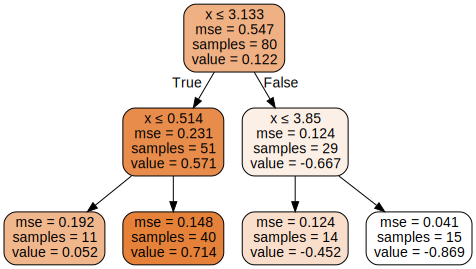

In [12]:
# Plot the DT
# If using Jupyter locally, install graphviz with this command: conda install python-graphviz
dot_data = export_graphviz(
    dt_reg_model1,
    out_file=None,
    feature_names=["x"],
    filled=True,
    rounded=True,
    special_characters=True,
)
graphviz.Source(dot_data)

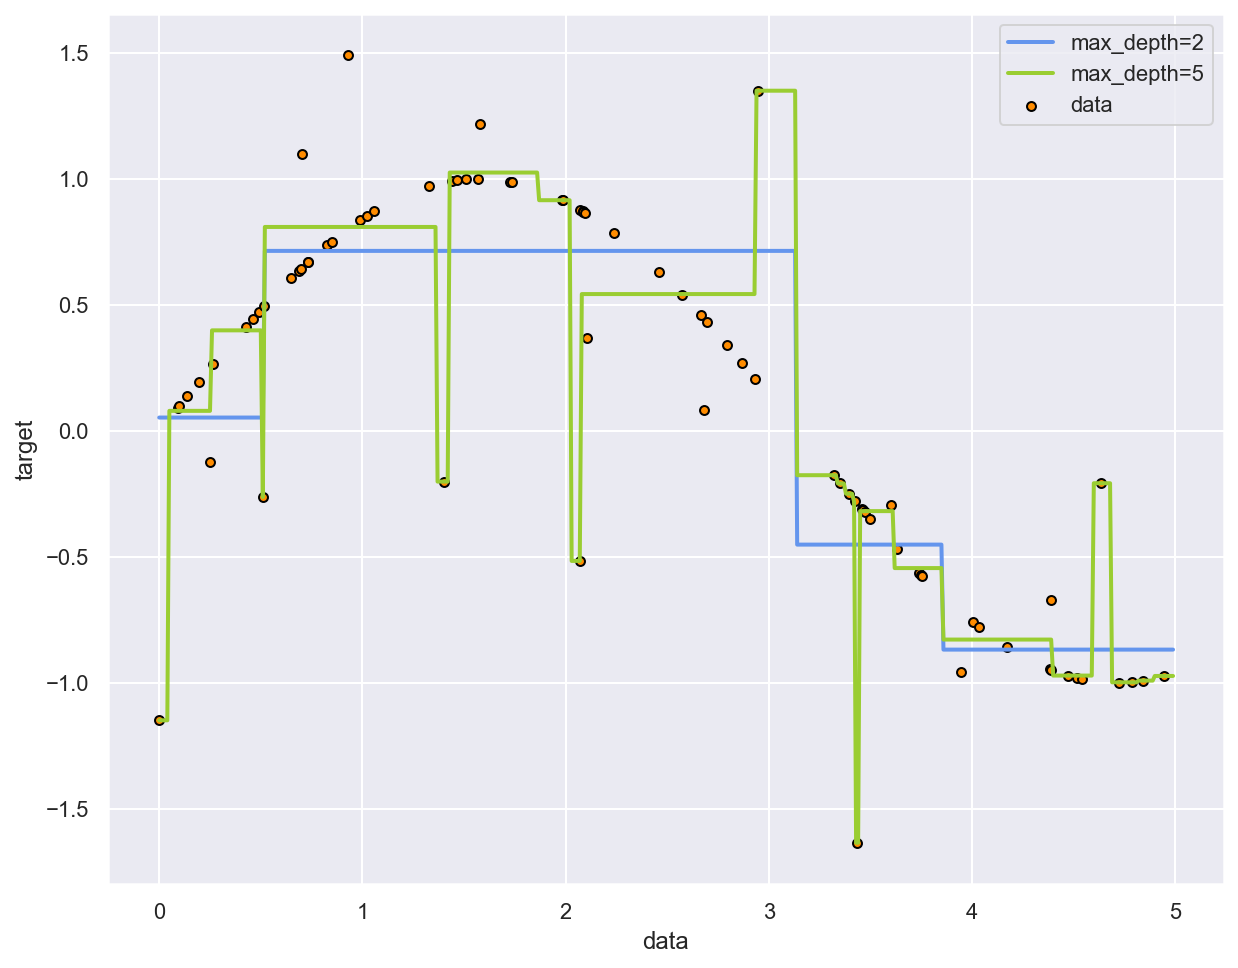

In [13]:
# Train another regression DT on same dataset
dt_reg_model2 = DecisionTreeRegressor(max_depth=5)
dt_reg_model2.fit(x_sin, y_sin)

# Predict values for both DT
x_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_pred_1 = dt_reg_model1.predict(x_test)
y_pred_2 = dt_reg_model2.predict(x_test)

# Plot the results
plt.figure()
plt.scatter(x_sin, y_sin, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(x_test, y_pred_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(x_test, y_pred_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.legend()
plt.show()

### Advantages of Decision Trees

- Versatility
- Very fast inference
- Intuitive and interpretable (*white box*)
- No feature scaling or encoding required

### Decision Trees shortcomings

- Main problem: **overfitting**. Regularization is possible through hyperparameters:
    - Maximum depth of the tree.
    - Minimum number of samples needed to split a node.
    - Minimum number of samples for any leaf node.
    - Maximum number of leaf nodes.
- Sensibility to small variations in the training data.

## Ensemble learning

(Heavily inspired by Chapter 7 of [Hands-On Machine Learning](https://github.com/ageron/handson-ml2) by Aurélien Géron)

### General idea

- Combining several predictors will lead to better results.
- A group of predictors is called an **ensemble**.
- Works best when predictors are diverse.
- Less interpretable and harder to tune than an individual predictor.

### Hard voting classifiers

[![Hard voting classifier](images/hard_voting_classifier.png)](https://github.com/ageron/handson-ml2)

### Soft voting classifiers

- Use class probabilities rather than class predictions.
- Often yields better results than hard voting (highly confident predictions have more weight).

### Bagging and pasting

Both methods train several predictors with the same algorithm on different random samples of the training set. The ensemble's result is computed by aggregating (i.e. most frequent or average) the predictions of individual predictors.

Only bagging (*bootstrap aggregating*) allows samples to be repeated for the same predictor.

[![Bagging & pasting](images/bagging_pasting.png)](https://github.com/ageron/handson-ml2)

### Boosting

Bagging and pasting methods rely on the simultaneous construction of several independent predictors.

On the contrary, boosting methods train predictors *sequentially*, each one trying to correct its predecessor.

#### AdaBoost

The core principle of AdaBoost (*Adaptative Boosting*) is to train several predictors on repeatedly modified versions of the dataset. The weights of incorrectly predicted instances are adjusted such that subsequent predictors focus more on difficult cases.

#### Gradient boosting

This methods train subsequent predictors on the *residual errors* made by the previous ones.

The ensemble's prediction is the sum of all individual predictions.

#### Example: gradient boosting for regression

In [14]:
def noisy_quadratic(x):
    return 3 * x[:, 0] ** 2 + 0.05 * np.random.randn(len(x))

# Generate a noisy quadratic dataset
x_boost = np.random.rand(100, 1) - 0.5
y_boost = noisy_quadratic(x_boost)


def grow_regression_tree(x, y):
    """Create and train a Decision Tree Regressor"""
    dtr_model = DecisionTreeRegressor(max_depth=2, random_state=42)
    dtr_model.fit(x, y)
    return dtr_model

In [15]:
# Train a DTR on initial dataset
dtr_model_1 = grow_regression_tree(x_boost, y_boost)
error_1 = y_boost - dtr_model_1.predict(x_boost)

# Train another DTR to predict the residual error of first DTR
dtr_model_2 = grow_regression_tree(x_boost, error_1)
error_2 = error_1 - dtr_model_2.predict(x_boost)

# Train another DTR to predict the residual error of second DTR
dtr_model_3 = grow_regression_tree(x_boost, error_2)
error_3 = error_2 - dtr_model_2.predict(x_boost)

In [16]:
# Generate test input and target
x_test = np.array([[0.05]])
y_test = noisy_quadratic(x_test)

# Compute error of first predictor
y_pred_1 = dtr_model_1.predict(x_test)
print(f"First DTR error: {abs(y_test - y_pred_1)}")

# Compute error of boosted ensemble
y_pred_ens = sum(dtr_model.predict(x_test) for dtr_model in (dtr_model_1, dtr_model_2, dtr_model_3))
print(f"Boosted ensemble error: {abs(y_test - y_pred_ens)}")

First DTR error: [0.03182588]
Boosted ensemble error: [0.06359804]


In [17]:
def plot_predictions(
    regressors, x, y, axes, label=None, style="r-", data_style="b.", data_label=None
):
    """Plot dataset and sum of predictions for one or several regressor(s)"""

    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(x[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

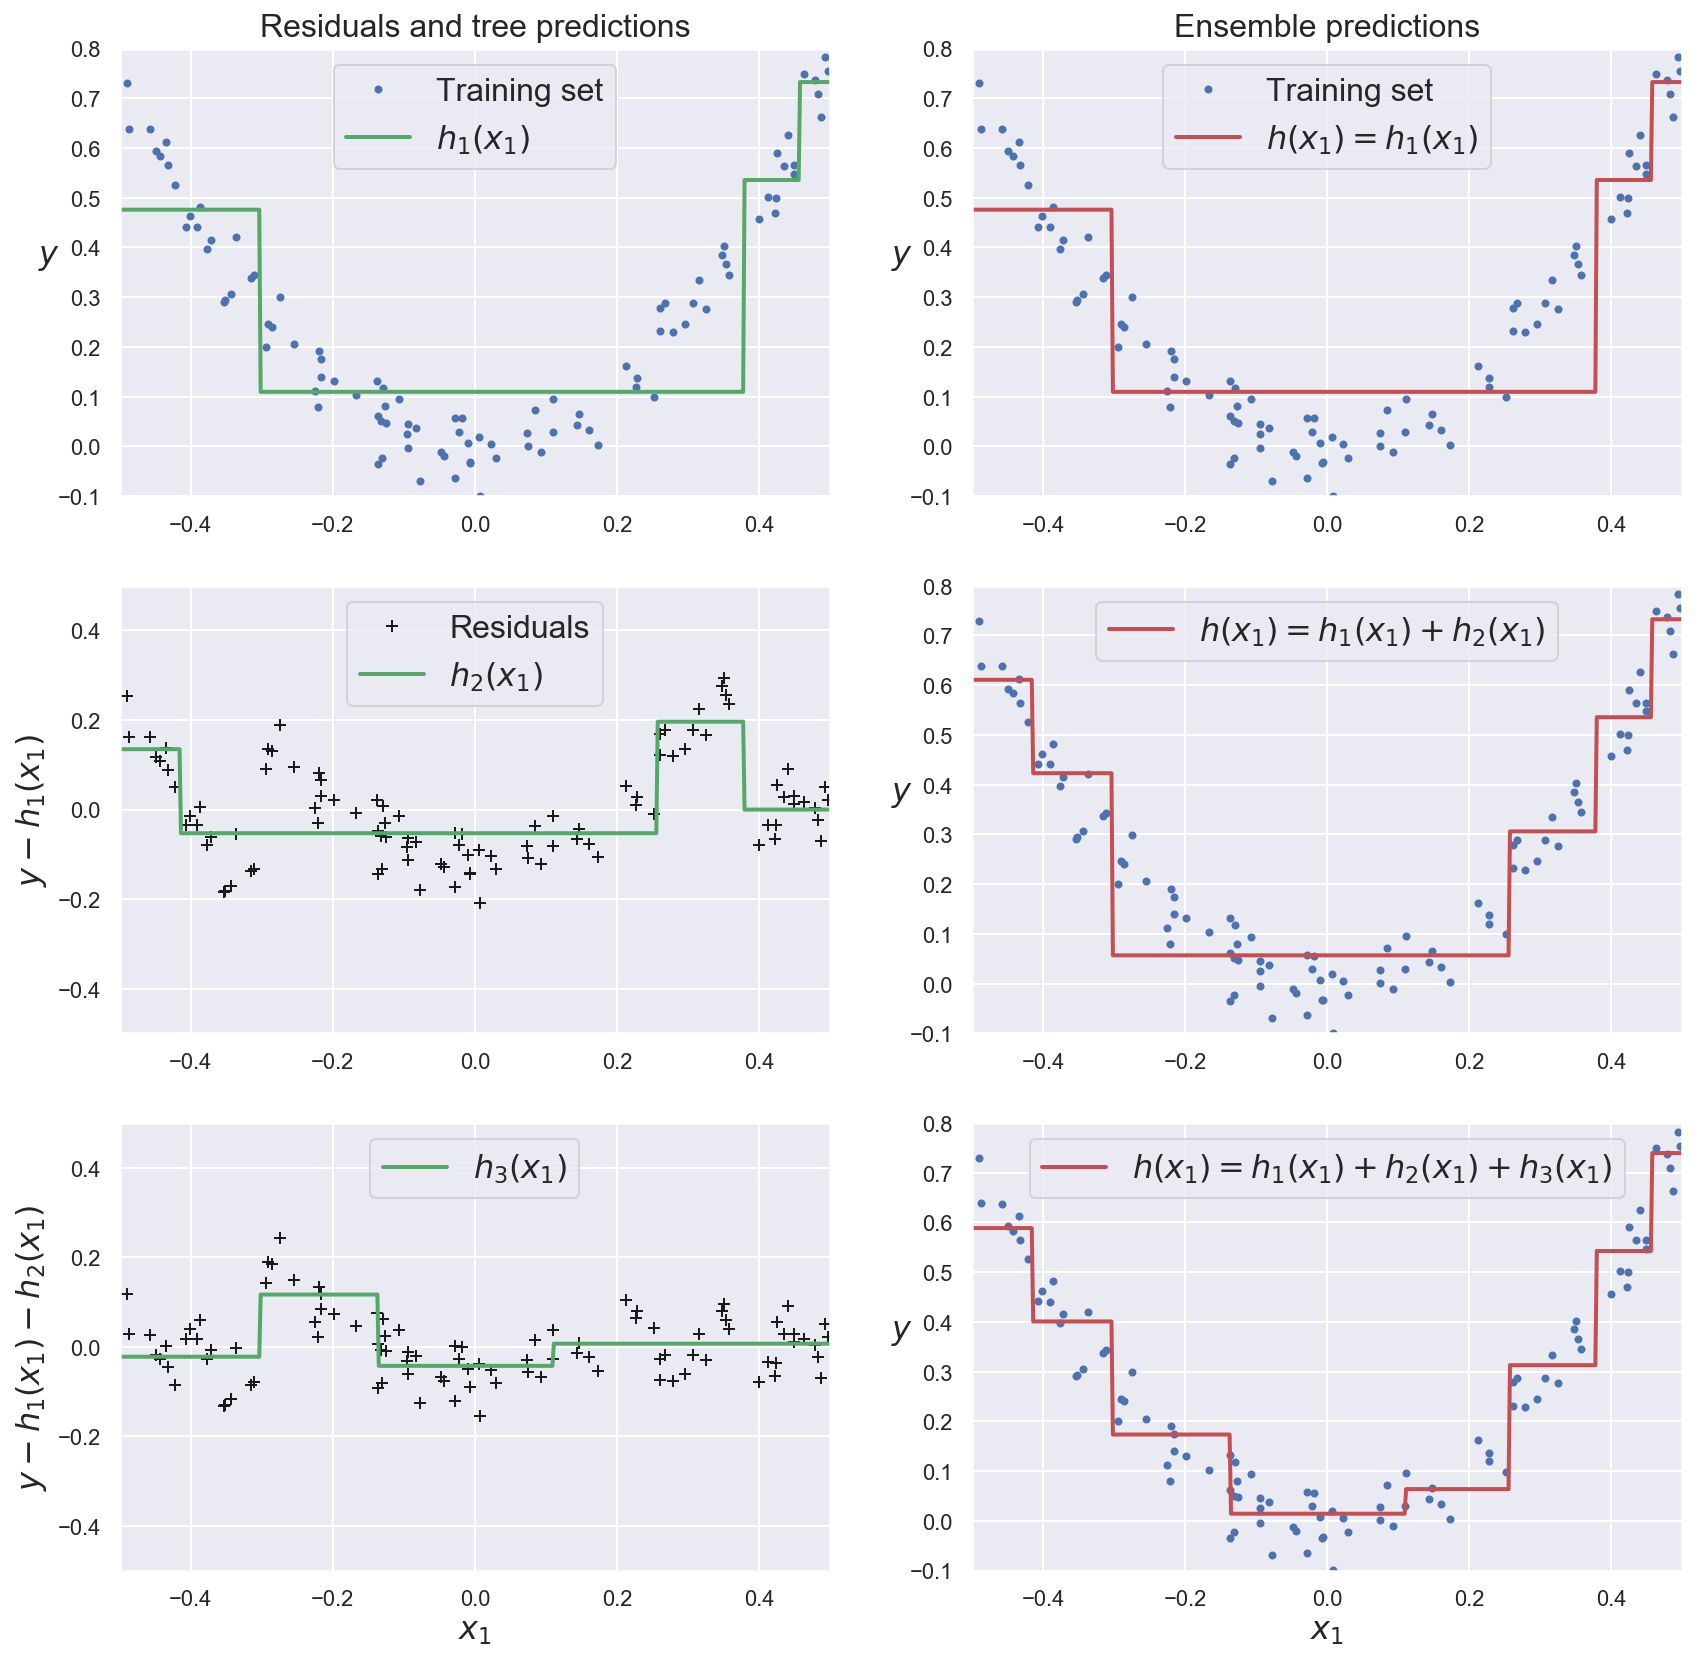

In [18]:
plt.figure(figsize=(14,14))

plt.subplot(321)
plot_predictions([dtr_model_1], x_boost, y_boost, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([dtr_model_1], x_boost, y_boost, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([dtr_model_2], x_boost, error_1, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([dtr_model_1, dtr_model_2], x_boost, y_boost, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([dtr_model_3], x_boost, error_2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([dtr_model_1, dtr_model_2, dtr_model_3], x_boost, y_boost, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

## Random Forests

### Random Forests in a nutshell

- Ensemble of Decision Trees, generally trained via bagging.
- May be used for classification or regression.
- Trees are grown using a random subset of features.
- Ensembling mitigates the individual shortcomings of Decision Trees (overfitting, sensibility to small changes in the dataset).
- On the other hand, results are less interpretable.

### Example: training a Random Forest to classify flowers

In [19]:
# Use whole Iris dataset
x_train = iris.data
y_train = iris.target

# Create a Random Forest classifier
# n_estimators: number of predictors (Decision Trees)
rf_model = RandomForestClassifier(n_estimators=200)

# Train the RF on the dataset
rf_model.fit(x_train, y_train)

# Compute cross-validation scores for the RF
scores = cross_val_score(rf_model, x_train, y_train, cv=5)

cv_acc = scores.mean()
print(f"Mean CV accuracy: {cv_acc:.05f}")

Mean CV accuracy: 0.96000
